In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 데이터 로드
data = pd.read_csv('dataset/dataset.csv')

# 데이터 기본 정보 확인
data.info()

# 데이터 통계 요약 확인
data.describe()

# 첫 몇 개의 샘플 데이터 확인
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avg_score                25000 non-null  float64
 1   plat_area                23675 non-null  float64
 2   arch_area                23675 non-null  float64
 3   bc_rat                   23675 non-null  float64
 4   tot_area                 23675 non-null  float64
 5   vl_rat                   23675 non-null  float64
 6   hhld_cnt                 23675 non-null  float64
 7   main_bld_cnt             23675 non-null  float64
 8   tot_pkng_cnt             23675 non-null  float64
 9   official_price           24394 non-null  float64
 10  crime_rank               25000 non-null  int64  
 11  longitude                24980 non-null  float64
 12  latitude                 24980 non-null  float64
 13  nearest_medical_related  24980 non-null  float64
 14  nearest_academy_relate

,avg_score,plat_area,arch_area,bc_rat,tot_area,vl_rat,hhld_cnt,main_bld_cnt,tot_pkng_cnt,official_price,...,longitude,latitude,nearest_medical_related,nearest_academy_related,nearest_laundry_related,nearest_market_related,nearest_park_related,nearest_library_related,nearest_school_related,nearest_transit_related
0,3.487179,693.7,414.5700,59.760000,4398.4800,475.42,63.0,1.0,41.0,11930000.0,...,127.097912,37.506006,0.096,0.084,0.043,0.219,0.168,0.354,0.261,0.118
1,3.600000,27677.2,4825.5706,17.435183,96645.0666,273.24,642.0,8.0,797.0,1020000.0,...,126.903353,35.179037,0.202,0.000,0.152,0.520,0.128,1.150,0.082,0.223
2,4.250000,211.0,124.8500,59.170000,440.0900,149.40,16.0,1.0,3.0,1192000.0,...,126.779951,37.685435,0.162,0.075,0.400,0.530,0.044,0.929,0.184,0.098
3,4.125000,27467.5,6252.6000,22.760000,74539.6800,170.76,571.0,12.0,695.0,3661000.0,...,126.840071,37.487681,0.141,0.112,0.350,0.512,0.264,1.393,0.238,0.138
4,4.000000,200.9,120.3800,59.920000,328.4900,163.51,8.0,1.0,2.0,1617000.0,...,126.780078,37.686948,0.056,0.095,0.260,0.665,0.132,0.771,0.287,0.115


In [3]:
# 결측치 처리
data.dropna(axis=0,inplace=True)

filtered_data = data[(data[['hhld_cnt', 'bc_rat', 'vl_rat']] != 0).all(axis=1)]

filtered_data['pkng_cnt_per_hhld_cnt'] = filtered_data.apply(lambda row: row['tot_pkng_cnt'] / row['hhld_cnt'], axis=1)

# 위도와 경도 피처 제거
filtered_data = filtered_data.drop(columns=['latitude', 'longitude','plat_area','arch_area','tot_area','main_bld_cnt','nearest_academy_related','nearest_library_related','tot_pkng_cnt','hhld_cnt'])

# 독립변수와 종속변수 분리
X = filtered_data.drop(columns=['avg_score'])
y = filtered_data['avg_score']

# 피처 스케일링 (종속변수를 제외한 나머지)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터프레임으로 변환
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_18172\1554058100.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['pkng_cnt_per_hhld_cnt'] = filtered_data.apply(lambda row: row['tot_pkng_cnt'] / row['hhld_cnt'], axis=1)


In [4]:
# avg_score 라벨링
def label_avg_score(score):
    if 0 <= score < 1.4:
        return 0
    elif 1.4 <= score < 2.3:
        return 1
    elif 2.3 <= score < 3.2:
        return 2
    elif 3.2 <= score < 4.1:
        return 3
    elif 4.1 <= score <= 5:
        return 4
    else:
        return -1  # 범위 밖인 경우

y_labeled = y.apply(label_avg_score)

# 각 클래스의 샘플 수 확인
class_counts = y_labeled.value_counts()
print(class_counts)

avg_score
3    8606
4    5454
2    2821
1    1445
0     452
Name: count, dtype: int64


In [5]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_labeled, test_size=0.2, random_state=42)

# SMOTE 적용 (훈련 데이터에만)
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 오버샘플링 후 각 클래스별 분포 확인
class_counts = y_train_resampled.value_counts()
print(class_counts)

avg_score
4    6901
3    6901
2    6901
0    6901
1    6901
Name: count, dtype: int64


In [6]:
# RandomForestClassifier 모델 훈련
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)

report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob, multi_class='ovo')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")
print(report)

Accuracy: 0.44914802981895635
AUC: 0.6607705021696286
              precision    recall  f1-score   support

           0       0.08      0.03      0.04        97
           1       0.20      0.25      0.22       283
           2       0.27      0.20      0.23       562
           3       0.55      0.64      0.59      1705
           4       0.43      0.37      0.40      1109

    accuracy                           0.45      3756
   macro avg       0.31      0.30      0.30      3756
weighted avg       0.43      0.45      0.44      3756



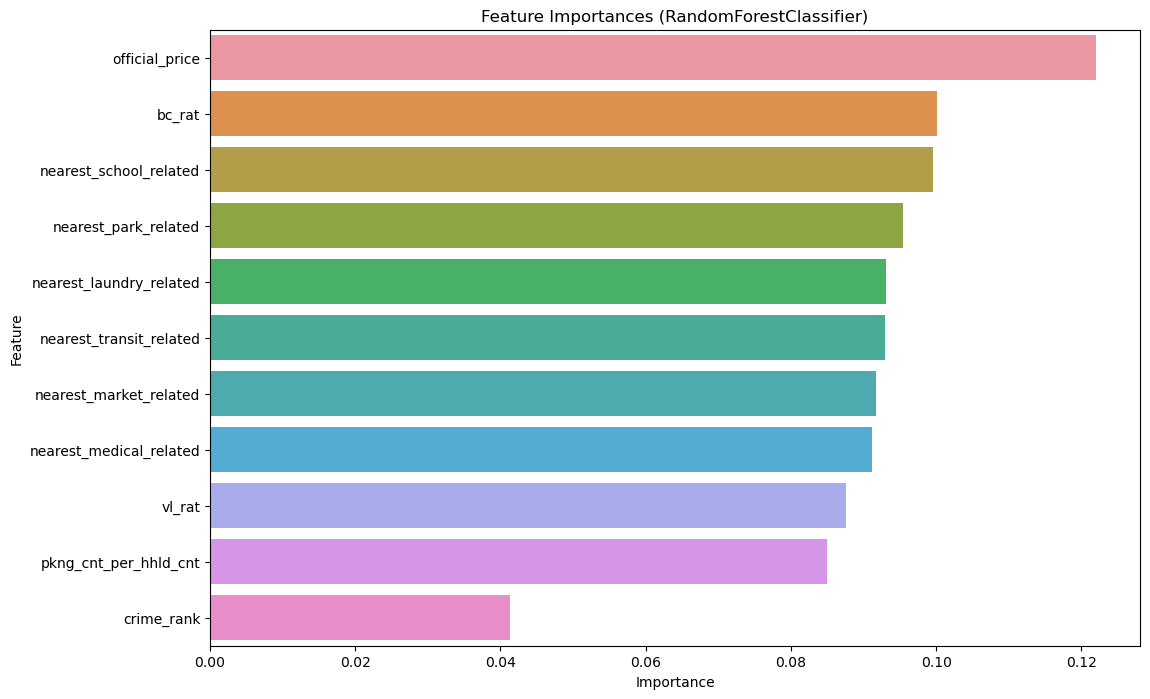

In [7]:
# 피처 중요도 시각화
feature_importances_rf = rf_model.feature_importances_
importance_df_rf = pd.DataFrame({'Feature': X_train_resampled.columns, 'Importance': feature_importances_rf}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf)
plt.title('Feature Importances (RandomForestClassifier)')
plt.show()

In [32]:
# pipeLine 작성 스케일링 -> 모델
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', rf_model)
])

rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# GridSearchCV를 활용하여 grid search 진행
rf_grid_search = GridSearchCV(estimator=pipeline, param_grid=rf_param_grid, cv=3, n_jobs=-1, scoring='accuracy')
rf_grid_search.fit(X_train_resampled, y_train_resampled)

# best model 추출
best_rf_model = rf_grid_search.best_estimator_
rf_best_params = rf_grid_search.best_params_

# best model 성능테스트
best_rf_y_pred = best_rf_model.predict(X_test)
best_rf_y_prob = best_rf_model.predict_proba(X_test)

best_rf_accuracy = accuracy_score(y_test, best_rf_y_pred)
best_rf_auc = roc_auc_score(y_test, best_rf_y_prob, multi_class='ovo')
best_rf_conf_matrix = confusion_matrix(y_test, best_rf_y_pred)
best_rf_report = classification_report(y_test, best_rf_y_pred)

print(f"Best RandomForestClassifier Accuracy: {best_rf_accuracy}")
print(f"Best RandomForestClassifier AUC: {best_rf_auc}")
print(f"Best RandomForestClassifier Parameters: {rf_best_params}")
print(best_rf_report)

Best RandomForestClassifier Accuracy: 0.45420660276890307
Best RandomForestClassifier AUC: 0.6631210889541775
Best RandomForestClassifier Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.05      0.02      0.03        97
           1       0.21      0.26      0.24       283
           2       0.29      0.21      0.24       562
           3       0.55      0.65      0.60      1705
           4       0.42      0.36      0.39      1109

    accuracy                           0.45      3756
   macro avg       0.31      0.30      0.30      3756
weighted avg       0.44      0.45      0.44      3756



['best_rf_model.pkl']

In [9]:
# scoring metrics 정의
scoring = {
    'accuracy': 'accuracy',
    'roc_auc_ovr': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')
}

# StratifiedKFold 세팅
strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# SMOTE, StandardScaler, RandomForestClassifier pipeline으로 구성
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', best_rf_model)
])

# cross_validate 진행
cv_results = cross_validate(pipeline, X_train, y_train, cv=strat_k_fold, scoring=scoring)

# cross_validate 성능평가
mean_accuracy = np.mean(cv_results['test_accuracy'])
mean_roc_auc = np.mean(cv_results['test_roc_auc_ovr'])

print(f"Cross-Validation Mean Accuracy (RandomForest): {mean_accuracy}")
print(f"Cross-Validation Mean AUC (RandomForest): {mean_roc_auc}")

C:\Users\SSAFY\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Cross-Validation Mean Accuracy (RandomForest): 0.4252428564973914
Cross-Validation Mean AUC (RandomForest): 0.6575940249630664


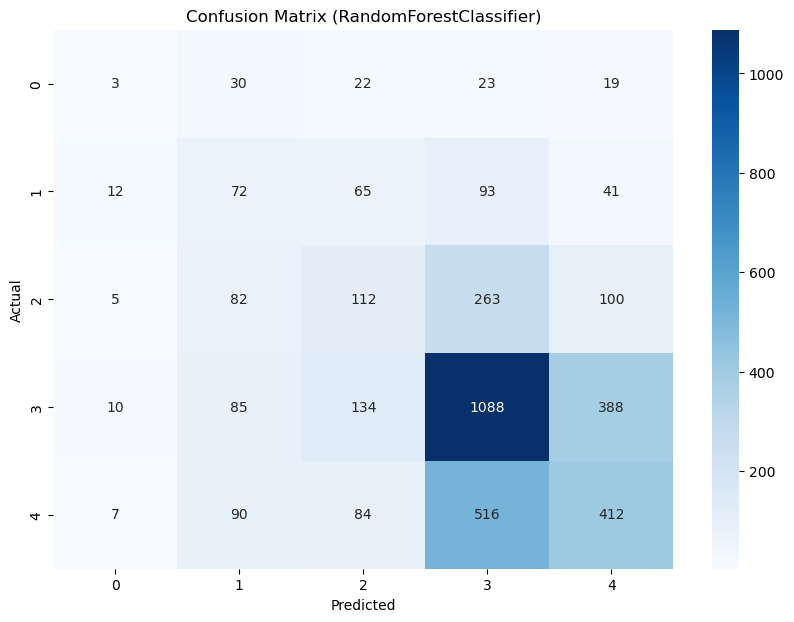

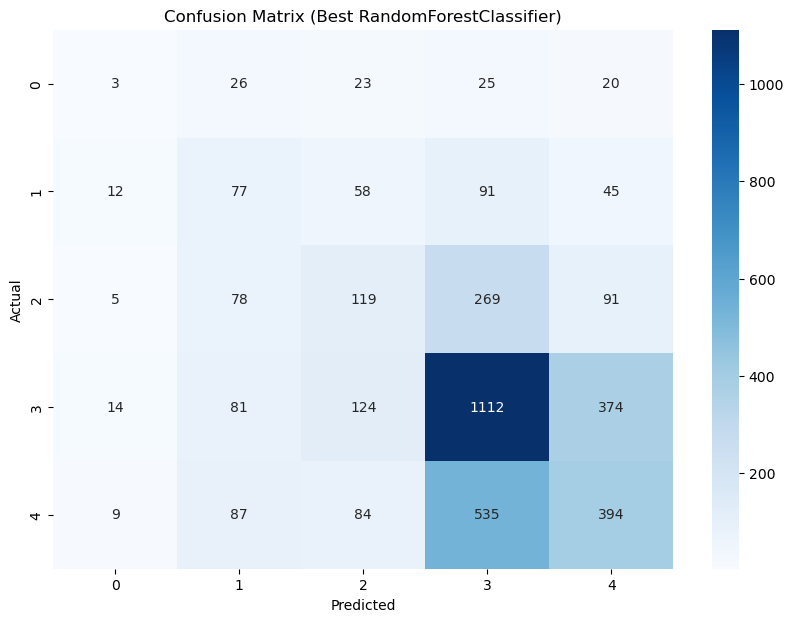

In [23]:
# 일반 RandomForestClassifier Confusion Matrix 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (RandomForestClassifier)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 하이퍼파라미터 튜닝 후 RandomForestClassifier Confusion Matrix 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(best_rf_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Best RandomForestClassifier)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [11]:
# 모델 학습 및 평가 (XGBoostClassifier)
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', n_estimators=50)
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)

# 예측 및 평가
report_xgb = classification_report(y_test, y_pred_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb, multi_class='ovo')
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print(f"Accuracy (XGBoost): {accuracy_xgb}")
print(f"AUC (XGBoost): {auc_xgb}")
print(report_xgb)

Accuracy (XGBoost): 0.39323748668796593
AUC (XGBoost): 0.643708202780884
              precision    recall  f1-score   support

           0       0.07      0.18      0.10        97
           1       0.20      0.27      0.23       283
           2       0.25      0.23      0.24       562
           3       0.53      0.53      0.53      1705
           4       0.38      0.31      0.35      1109

    accuracy                           0.39      3756
   macro avg       0.29      0.30      0.29      3756
weighted avg       0.41      0.39      0.40      3756



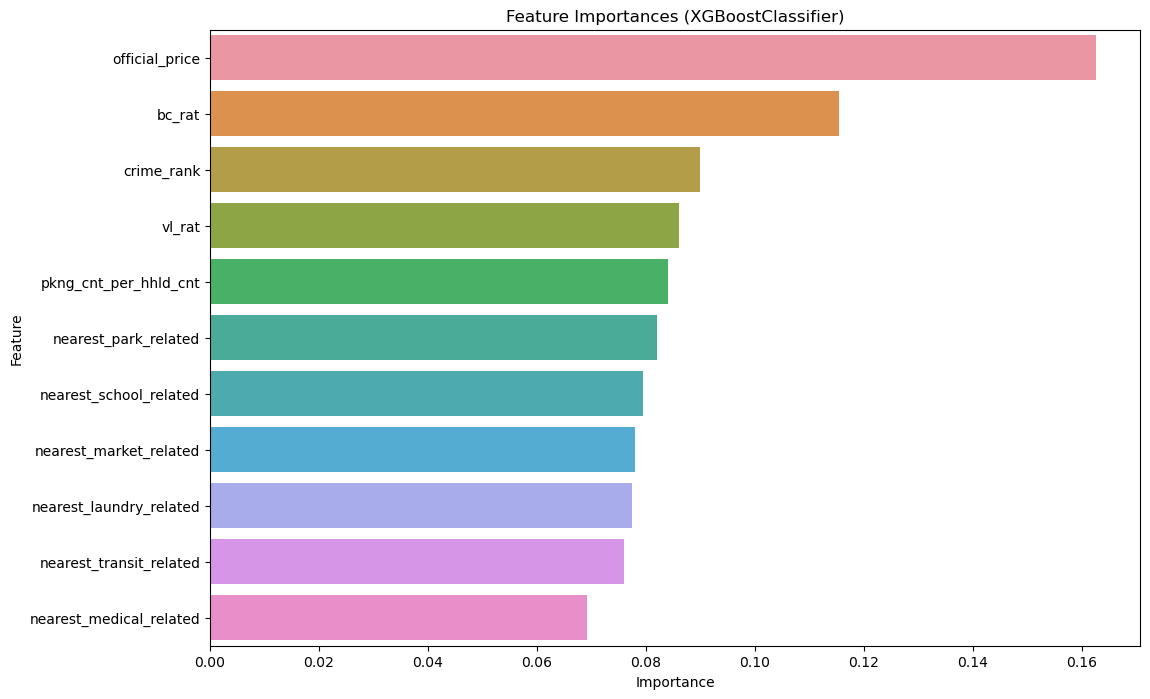

In [12]:
# 피처 중요도 시각화 (XGBoostClassifier)
feature_importances_xgb = xgb_model.feature_importances_
importance_df_xgb = pd.DataFrame({'Feature': X_train_resampled.columns, 'Importance': feature_importances_xgb}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_xgb)
plt.title('Feature Importances (XGBoostClassifier)')
plt.show()

In [13]:
# XGBClassifier 하이퍼파라미터 튜닝
xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_grid_search = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), param_grid=xgb_param_grid, cv=3, n_jobs=-1, scoring='accuracy')
xgb_grid_search.fit(X_train_resampled, y_train_resampled)

best_xgb_model = xgb_grid_search.best_estimator_
xgb_best_params = xgb_grid_search.best_params_

# 최적 모델 평가
best_xgb_y_pred = best_xgb_model.predict(X_test)
best_xgb_y_prob = best_xgb_model.predict_proba(X_test)

best_xgb_accuracy = accuracy_score(y_test, best_xgb_y_pred)
best_xgb_auc_xgb = roc_auc_score(y_test, best_xgb_y_prob, multi_class='ovo')
best_xgb_conf_matrix_xgb = confusion_matrix(y_test, best_xgb_y_pred)
best_xgb_report = classification_report(y_test, best_xgb_y_pred)

print(f"Best XGBoostClassifier Accuracy: {best_xgb_accuracy}")
print(f"Best XGBoostClassifier Parameters: {xgb_best_params}")
print(best_xgb_report)

Best XGBoostClassifier Accuracy: 0.43264110756123536
Best XGBoostClassifier Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.12      0.06      0.08        97
           1       0.21      0.19      0.20       283
           2       0.25      0.20      0.22       562
           3       0.53      0.62      0.57      1705
           4       0.39      0.36      0.37      1109

    accuracy                           0.43      3756
   macro avg       0.30      0.29      0.29      3756
weighted avg       0.41      0.43      0.42      3756



In [14]:
# 교차 검증 (XGBoostClassifier)
# scoring metrics 정의
scoring = {
    'accuracy': 'accuracy',
    'roc_auc_ovr': make_scorer(roc_auc_score, multi_class='ovr', response_method='predict_proba')
}

# StratifiedKFold 세팅
strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# SMOTE, StandardScaler, RandomForestClassifier pipeline 구성
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', best_xgb_model)
])

# cross_validate 진행
cv_results = cross_validate(pipeline, X_train, y_train, cv=strat_k_fold, scoring=scoring)

# cross_validate 성능평가
mean_score_xgb = np.mean(cv_results['test_accuracy'])
mean_auc_xgb = np.mean(cv_results['test_roc_auc_ovr'])

print(f"Cross-Validation Mean Accuracy (XGBoost): {mean_score_xgb}")
print(f"Cross-Validation Mean AUC (XGBoost): {mean_auc_xgb}")

Cross-Validation Mean Accuracy (XGBoost): 0.415390390988994
Cross-Validation Mean AUC (XGBoost): 0.6365062567494253


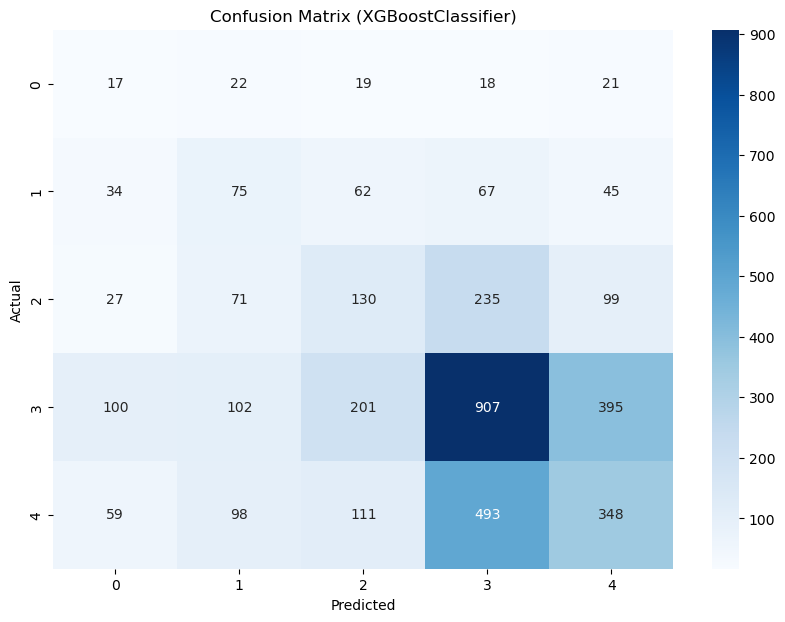

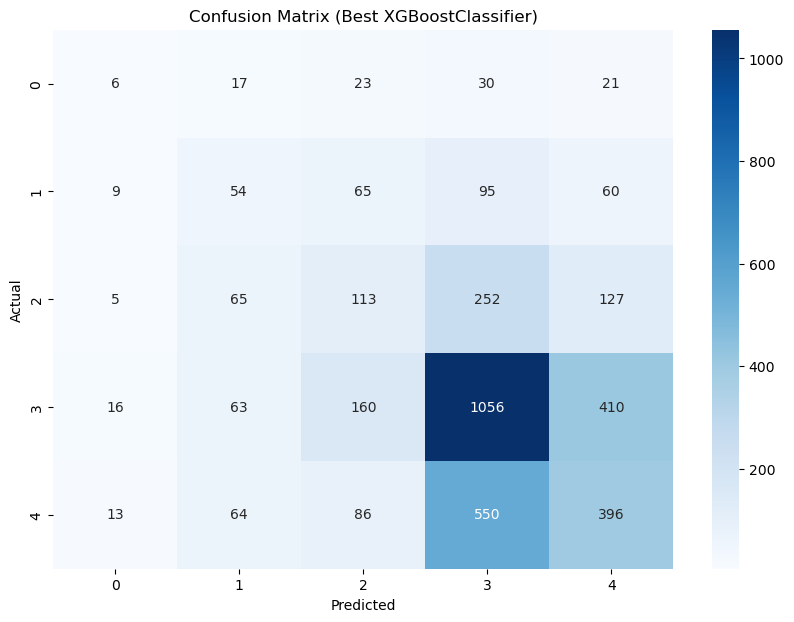

In [15]:
# Confusion Matrix 시각화 (XGBoostClassifier)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (XGBoostClassifier)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 하이퍼 파라미터 튜닝 후, Confusion Matrix 시각화 (XGBoostClassifier)
plt.figure(figsize=(10, 7))
sns.heatmap(best_xgb_conf_matrix_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Best XGBoostClassifier)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [30]:
# LightGBMClassifier 모델
# 모델 학습 및 평가 (LightGBMClassifier)
lgb_model = lgb.LGBMClassifier(random_state=42, n_estimators=50)
lgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_lgb = lgb_model.predict(X_test)
y_prob_lgb = lgb_model.predict_proba(X_test)

# 예측 및 평가
report_lgb = classification_report(y_test, y_pred_lgb)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
auc_lgb = roc_auc_score(y_test, y_prob_lgb, multi_class='ovo')
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)

print(f"Accuracy (LightGBM): {accuracy_lgb}")
print(f"AUC (LightGBM): {auc_lgb}")
print(report_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 34505, number of used features: 11
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Accuracy (LightGBM): 0.42039403620873267
AUC (LightGBM): 0.660807213922814
              precision    recall  f1-score   support

           0       0.07      0.20      0.10        97
           1       0.21      0.34      0.26       283
           2       0.28      0.19      0.22       562
           3       0.55      0.57      0.56      1705
           4       0.43      0.34      0.38      1109

    accuracy                           0

In [21]:
lgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'boosting_type': ['gbdt', 'dart'],
    'min_child_samples': [20, 30, 40]
}

grid_search_lgb = GridSearchCV(lgb.LGBMClassifier(random_state=42), lgb_param_grid, cv=strat_k_fold, scoring='roc_auc_ovr', n_jobs=-1)

grid_search_lgb.fit(X_train_resampled, y_train_resampled)

best_lgb_model = grid_search_lgb.best_estimator_

y_pred_best_lgb = best_lgb_model.predict(X_test)
y_prob_best_lgb = best_lgb_model.predict_proba(X_test)
test_accuracy_best_lgb = accuracy_score(y_test, y_pred_best_lgb)
test_roc_auc_best_lgb = roc_auc_score(y_test, y_prob_best_lgb, multi_class='ovo')
classification_rep_best_lgb = classification_report(y_test, y_pred_best_lgb)

print(f"Test Set Accuracy (Best LightGBM): {test_accuracy_best_lgb}")
print(f"Test Set AUC (Best LightGBM): {test_roc_auc_best_lgb}")
print(classification_rep_best_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 34505, number of used features: 11
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Test Set Accuracy (Best LightGBM): 0.4438232161874334
Test Set AUC (Best LightGBM): 0.6359177081799946
              precision    recall  f1-score   support

           0       0.05      0.01      0.02        97
           1       0.27      0.22      0.24       283
           2       0.28      0.22      0.24       562
           3       0.53      0.62      0.57      1705
           4       0.39      0.38      0.39      1109

    accuracy

In [31]:
# 교차 검증 (LightGBMClassifier)
scoring = {
    'accuracy': 'accuracy',
    'roc_auc_ovr': make_scorer(roc_auc_score, multi_class='ovr', response_method='predict_proba')
}

strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', best_lgb_model)
])

cv_results = cross_validate(pipeline, X_train, y_train, cv=strat_k_fold, scoring=scoring)

mean_score_lgb = np.mean(cv_results['test_accuracy'])
mean_auc_lgb = np.mean(cv_results['test_roc_auc_ovr'])

print(f"Cross-Validation Mean Accuracy (LightGBMClassifier): {mean_score_lgb}")
print(f"Cross-Validation Mean AUC (LightGBMClassifier): {mean_auc_lgb}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 31055, number of used features: 11
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 31055, number of used features: 11
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score 

In [33]:
# Stacking Classifier 모델
# 평가 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'roc_auc_ovr': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')
}

# Stratified K-Fold 교차 검증 설정
strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Stacking Classifier 생성
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', best_rf_model),  # RandomForest 모델
        ('xgb', best_xgb_model)  # XGBoost 모델
    ],
    final_estimator=RandomForestClassifier(random_state=42),  # 최종 메타 모델
    cv=strat_k_fold,
    n_jobs=-1
)

# SMOTE, StandardScaler, StackingClassifier를 포함한 파이프라인 생성
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', stacking_clf)
])

# cross_validate를 사용한 교차 검증 수행
cv_results = cross_validate(pipeline, X_train, y_train, cv=strat_k_fold, scoring=scoring)

# 평균 점수 계산
mean_accuracy = np.mean(cv_results['test_accuracy'])
mean_roc_auc = np.mean(cv_results['test_roc_auc_ovr'])

print(f"Cross-Validation Mean Accuracy (Stacking Classifier): {mean_accuracy}")
print(f"Cross-Validation Mean AUC (Stacking Classifier): {mean_roc_auc}")

# 전체 훈련 데이터로 최종 모델 학습
pipeline.fit(X_train, y_train)

# 테스트 데이터에서 평가
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
classification_rep = classification_report(y_test, y_pred)

print(f"Test Set Accuracy: {test_accuracy}")
print(f"Test Set AUC: {test_roc_auc}")
print(classification_rep)

C:\Users\SSAFY\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Cross-Validation Mean Accuracy (Stacking Classifier): 0.43982252981830394
Cross-Validation Mean AUC (Stacking Classifier): 0.6233360920581664
Test Set Accuracy: 0.44329073482428116
Test Set AUC: 0.6294222821396652
              precision    recall  f1-score   support

           0       0.07      0.04      0.05        97
           1       0.24      0.24      0.24       283
           2       0.29      0.22      0.25       562
           3       0.52      0.68      0.59      1705
           4       0.41      0.29      0.34      1109

    accuracy                           0.44      3756
   macro avg       0.31      0.29      0.29      3756
weighted avg       0.42      0.44      0.42      3756



In [ ]:
# 최적 모델 저장
joblib.dump(best_rf_model, 'model.pkl')